In [1]:
import mpld3
mpld3.enable_notebook()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings ("ignore")
i=300


Using TensorFlow backend.
C:\Users\hamim\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hamim\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hamim\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hamim\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
def get_y_from_generator(gen):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    #print(y.shape)
    return y



In [3]:
def binary_accuracy(a, b):
    '''
    Helper function to compute the match score of two
    binary numpy arrays.
    '''
    assert len(a) == len(b)
    return (a == b).sum() / len(a)


In [4]:
df = pd.read_csv('sample.csv', usecols=[0,9])
df.rename(columns = {"'Time and date'":'Time',"'ABP'":'ABP'}, inplace = True)
df['Time']=df['Time'].apply(lambda x: x.replace('[','').replace(']',''))
df.Time = pd.to_datetime(df.Time)
df=df.set_index('Time')


In [7]:
def data_set(t1):
    t2=t1+200
    data=df[:t2]
    train  =data[:t1]
    test=data[t1:t2]
    scaler=MinMaxScaler()
    train=scaler.fit_transform(train)
    test= scaler.fit_transform(test)
    plt.plot(data)
    plt.ylabel('ABP')
    plt.xlabel('Time')
    plt.show()


    look_back=3
    train_data_gen = TimeseriesGenerator(train, train, length=look_back, sampling_rate=1,stride=1,batch_size=3)
    test_data_gen = TimeseriesGenerator(test, test,length=look_back, sampling_rate=1,stride=1,batch_size=1)


    model = Sequential()
    model.add(LSTM(4, input_shape=(look_back, 1)))
    model.add(Dense(1))#one output value
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit_generator(train_data_gen, epochs=100,verbose=0).history

    model.evaluate_generator(test_data_gen)
    trainPredict = model.predict_generator(train_data_gen)
    #trainPredict.shape
    testPredict = model.predict_generator(test_data_gen)
    #testPredict.shape
    trainPredict = scaler.inverse_transform(trainPredict)
    testPredict = scaler.inverse_transform(testPredict)

    trainY = get_y_from_generator(train_data_gen)
    testY = get_y_from_generator(test_data_gen)
    trainY = scaler.inverse_transform(trainY)
    testY = scaler.inverse_transform(testY)

    from sklearn.metrics import mean_squared_error
    import math
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
    testScore = math.sqrt(mean_squared_error(testY[:, 0], testPredict[:,0]))
    

# shift train predictions for plotting
    trainPredictPlot = np.empty_like(data)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # Delta + previous close
    trainPredictPlot = trainPredictPlot + data
    # set empty values
    # trainPredictPlot[0:look_back, :] = np.nan
    # trainPredictPlot[len(trainPredict)+look_back:, :] = np.nan


# shift test predictions for plotting
    testPredictPlot = np.empty_like(data)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2):len(data), :] = testPredict

    # Delta + previous close
    testPredictPlot = testPredictPlot + data
    # set empty values
    # testPredictPlot[0:len(trainPredict)+(look_back*2), :] = np.nan
    # testPredictPlot[len(dataset):, :] = np.nan


# plot baseline and predictions
    fig = plt.figure(figsize=(10, 5))

    plt.plot(data+data-data,label='Real')
    plt.plot(trainPredictPlot-data,label='Train Predict')
    plt.plot(testPredictPlot-data,label="Test Predict")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("ABP")
    plt.show()

    plt.plot(data )
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()

    #preparing data for confusion matrix and accuracy calculation
    flat_list1 = [item for sublist in testY for item in sublist]
    flat_list2 = [item for sublist in testPredict for item in sublist]
    s=len(flat_list1)
    w=10
    result1=[]
    result1_1=[]

    result2=[]
    result2_2=[]
    for i in range(0,s,w):
        list1=flat_list1[i:i+w]
        list2=flat_list2[i:i+w]

        d1=len([j1 for j1 in list1 if j1 >= 60])
        d2=len([j2 for j2 in list1 if j2 >= 60])
        e1=int((d1/w)*100)
        e2=int((d2/w)*100)
        if e1==100:
            result1.append(1)
            result1_1.append((1,"NORMAL",e1))
        if e1<=10:
            result1.append(2)
            result1_1.append((2,"AHE",e1))
        if(e1>10 and e1<100):
            result1.append(3)
            result1_1.append((3,"ALERT",e1))
        if e2==100:
            result2.append(1)
            result2_2.append((1,"NORMAL",e2))

        if e2<=10:
            result2.append(2)
            result2_2.append((2,"AHE",e2))
        if(e2>10 and e2<100):
            result2.append(3)
            result2_2.append((3,"ALERT",e2))


    print (result1_1)
    print (result2_2)
    #confusion matrix and accuracy
    from sklearn.metrics import confusion_matrix
    arr1=np.array(result1)
    arr2=np.array(result2)
    TN, FP, FN, TP=confusion_matrix(arr1,arr2).ravel()

    SE=TP/(TP+FN)
    SP=TN/(TN+FP)
    AC=(TP+TN)/(TP+TN+FP+FN)
    print ("SE: ",SE*100,"%")
    print ("SP: ",SP*100,"%")
    print ("AC: ",AC*100,"%")
    print('Train Score: %.2f RMSE' % (trainScore))
    print('Test Score: %.2f RMSE' % (testScore))

    


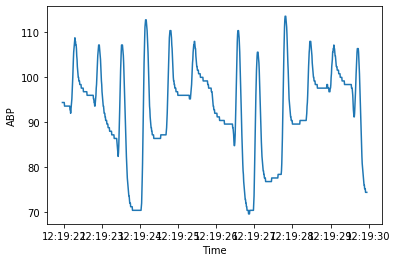

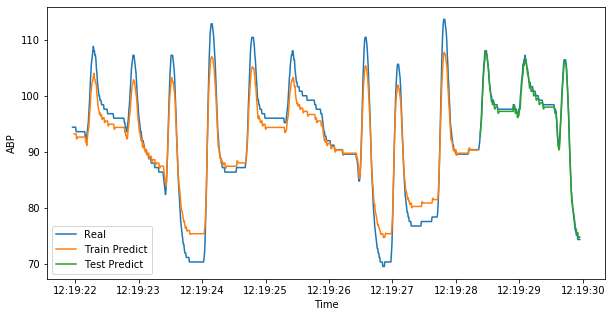

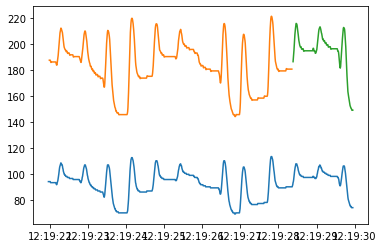

[(1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (3, 'ALERT', 70)]
[(1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (1, 'NORMAL', 100), (3, 'ALERT', 70)]
SE:  100.0 %
SP:  100.0 %
AC:  100.0 %
Train Score: 0.43 RMSE
Test Score: 0.63 RMSE


In [8]:
#this loop is used to change the train data size (t1,t2.....tn)
while True:
    data_set(i)
    i+=100
    if (i==900):
       break
